### Нейронные сети. Зависимость ошибки и обучающей способности от числа нейронов
В этом задании вы будете настраивать двуслойную нейронную сеть для решения задачи многоклассовой классификации. Предлагается выполнить процедуры загрузки и разбиения входных данных, обучения сети и подсчета ошибки классификации. Предлагается определить оптимальное количество нейронов в скрытом слое сети. Нужно так подобрать число нейронов, чтобы модель была с одной стороны несложной, а с другой стороны давала бы достаточно точный прогноз и не переобучалась. 
- Цель задания - показать, как зависит точность и обучающая способность сети от ее сложности.

Для решения задачи многоклассовой классификации предлагается воспользоваться библиотекой построения нейронных сетей [pybrain](http://pybrain.org/). Библиотека содержит основные модули инициализации двуслойной нейронной сети прямого распространения, оценки ее параметров с помощью метода обратного распространения ошибки (backpropagation) и подсчета ошибки.

Установить библиотеку ```pybrain``` можно с помощью стандартной системы управления пакетами pip

###  Используемые данные
Рассматривается задача оценки качества вина по его физико-химическим свойствам. Данные размещены в репозитории UCI  и содержат 1599 образцов красного вина, описанных 11 признаками, среди которых: 
- кислотность
- процентное содержание сахара, алкоголя и пр.

Кроме того, каждому объекту поставлена в соответствие оценка качества по шкале от 0 до 10. Требуется восстановить оценку качества вина по исходному признаковому описанию.

In [137]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

### Загрузка данных
В качестве альтернативного варианта, можно выполнить загрузку данных напрямую из репозитория UCI, воспользовавшись библиотекой urllib (т.е. загрузкой через инет)

In [138]:
cd C:\Users\vlad\Machine_Learning\Yandex Specialization\2.Supervised Learning\Data

C:\Users\vlad\Machine_Learning\Yandex Specialization\2.Supervised Learning\Data


In [139]:
data = pd.read_csv('winequality_red.csv', sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


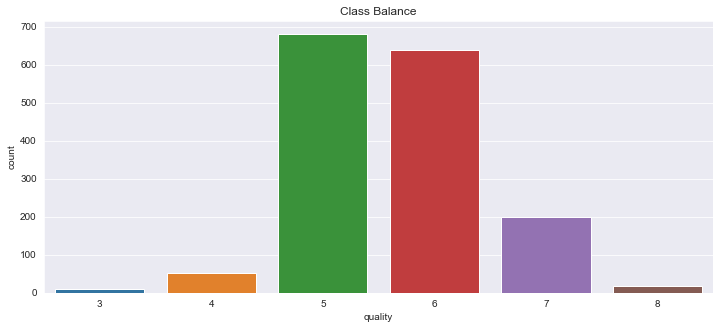

In [140]:
# Взглянем на баланс классов
plt.figure(figsize=(12,5))
sns.countplot(data['quality'])
plt.title('Class Balance');

Выделим из данных целевую переменную. Классы в задаче являются несбалинсированными: основной доле объектов поставлена оценка качества от 5 до 7. Врядли мы сможем эффективно предсказать класс, учитывая такой дисбаланс. Хорошим решением может стать приведение задачи к 3-х классовой. Объектам с оценкой качества меньше пяти поставим оценку 5, а объектам с оценкой качества больше семи поставим 7. 

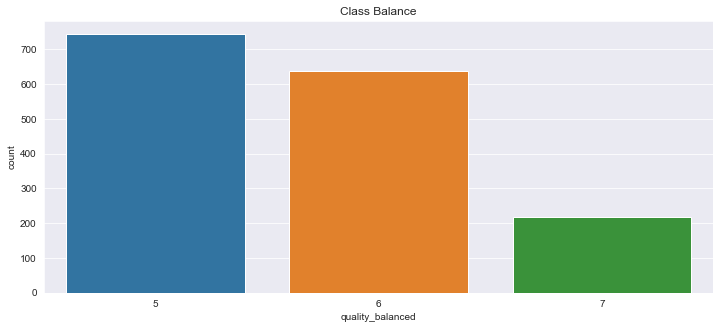

In [141]:
# Изменим баланс классов
data['quality_balanced'] = data['quality'].apply(lambda x: 5 if x < 5 else 7 if x > 7 else x)

# Взглянем на измененный баланс классов
plt.figure(figsize=(12,5))
sns.countplot(data['quality_balanced'])
plt.title('Class Balance');

Так намного лучше, но дисбаланс классов все равно присутствует. Возможно неудобно использовать обозначения классов как 5, 6 и 7. Изменим на 0, 1 и 2.

In [142]:
# Приводим к классам 0, 1 и 2
data['quality_balanced'] = data['quality_balanced'] - data['quality_balanced'].min()

In [143]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_balanced
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023,0.670419
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569,0.701915
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000,1.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,2.000000


Данный не отмасштабированны, максимальные значения некоторых признаков слишком большие и отличаются в десятки раз.

In [144]:
# Выделим матрицу объекты-признаки и целевую переменную
x = data.iloc[:, :-2]
y = data['quality_balanced']

# Матрица объекты-признаки должна отшкалированна. Применим нормализацию 
x = normalize(x)

# Разбиваем выборку на обучение и тест
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

### Двуслойная нейронная сеть

Двуслойная нейронная сеть представляет собой функцию распознавания, которая може быть записана в виде следующей суперпозиции:

$f(x,W)=h^{(2)}\left(\sum\limits_{i=1}^D w_i^{(2)}h^{(1)}\left(\sum\limits_{j=1}^n w_{ji}^{(1)}x_j+b_i^{(1)}\right)+b^{(2)}\right)$, где

- $x$ исходный объект (сорт вина, описанный 11 признаками)

- $x_j$ соответствующий признак

- $n$ количество нейронов во входном слое сети, совпадающее с количеством признаков

- $D$ количество нейронов в скрытом слое сети

- $w_i^{(2)}, w_{ji}^{(1)}, b_i^{(1)}, b^{(2)}$ параметры сети, соответствующие весам нейронов

- $h^{(1)}, h^{(2)}$ функции активации

В качестве функции активации на скрытом слое сети используется линейная функция. На выходном слое сети используется функция активации ```softmax```, являющаяся обобщением сигмоидной функции на многоклассовый случай:

$y_k=\text{softmax}_k(a_1,...,a_k)=\frac{\exp(a_k)}{\sum_{k=1}^K\exp(a_k)}$

### Настройка параметров сети

Оптимальные параметры сети $W_{opt}$ определяются путем минимизации функции ошибки:

$W_{opt}=\arg\min\limits_{W}L(W)+\lambda\|W\|^2$

- $L(W)$ является функцией ошибки многоклассовой классификации,

$L(W)=- \sum^N_{n=1}\sum^K_{k=1} t_{kn} log(y_{kn})$

- $t_{kn}$ бинарно закодированные метки классов
- $K$ количество меток
- $N$ -- количество объектов
- $\lambda\|W\|^2$ является регуляризующим слагаемым, контролирующим суммарный вес параметров сети и предотвращающий эффект переобучения.

Оптимизация параметров выполняется методом обратного распространения ошибки (backpropagation)

Выполним загрузку основных модулей: 
- ```ClassificationDataSet``` структура данных pybrain
- ```buildNetwork``` инициализация нейронной сети
- ```BackpropTrainer``` оптимизация параметров сети методом backpropagation
- ```SoftmaxLayer``` функция softmax, соответствующая выходному слою сети
- ```percentError``` функцию подсчета ошибки классификации (доля неправильных ответов). 

In [145]:
from pybrain3.datasets import ClassificationDataSet # Структура данных pybrain
from pybrain3.tools.shortcuts import buildNetwork # Инициализация нейронной сети
from pybrain3.supervised.trainers import BackpropTrainer # Оптимизация параметров сети методом backpropagation
from pybrain3.structure.modules import SoftmaxLayer, LinearLayer # Функция softmax, соответствующая выходному слою сети
from pybrain3.utilities import percentError # Функция подсчета ошибки классификации

Инициализируем основные параметры задачи:
- ```HIDDEN_NEURONS_NUM``` количество нейронов скрытого слоя
- ```MAX_EPOCHS``` максимальное количество итераций алгоритма оптимизации

In [146]:
# Определение основных констант
HIDDEN_NEURONS_NUM = 100 # Количество нейронов, содержащееся в скрытом слое сети
MAX_EPOCHS = 100 # Максимальное число итераций алгоритма оптимизации параметров сети

Инициализируем структуру данных ```ClassificationDataSet```, используемую библиотекой pybrain. Для инициализации структура принимает два аргумента: 
- Количество признаков ```np.shape(X)[1]```
- Количество различных меток классов ```len(np.unique(y))```

Кроме того, произведем бинаризацию целевой переменной с помощью функции ```_convertToOneOfMany( )``` и разбиение данных на обучающую и контрольную части.

In [147]:
# На обучение
ds_train = ClassificationDataSet(np.shape(x)[1], nb_classes=len(np.unique(y_train)))
ds_train.setField('input', x_train) # Инициализация объектов
ds_train.setField('target', y_train[:, np.newaxis]) # Инициализация ответов (нужен вектор столбец)
ds_train._convertToOneOfMany( ) # Бинаризация вектора ответов

# На тест 
ds_test = ClassificationDataSet(np.shape(x)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', x_test)
ds_test.setField('target', y_test[:, np.newaxis])
ds_test._convertToOneOfMany( )

Инициализируем двуслойную сеть и произведем оптимизацию ее параметров. Аргументами для инициализации являются:
- ```ds.indim``` количество нейронов на входном слое сети, совпадает с количеством признаков (в нашем случае 11)
- ```HIDDEN_NEURONS_NUM``` - количество нейронов в скрытом слое сети
- ```ds.outdim``` - количество нейронов на выходном слое сети, совпадает с количеством различных меток классов (в нашем случае 3)
- ```SoftmaxLayer``` функция softmax, используемая на выходном слое для решения задачи многоклассовой классификации.

In [148]:
np.random.seed(0) 

# Построение сети прямого распространения (Feedforward network)
neural_net = buildNetwork(ds_train.indim, HIDDEN_NEURONS_NUM, ds_train.outdim, hiddenclass=LinearLayer, outclass=SoftmaxLayer)

init_params = np.random.random((len(neural_net.params))) # Инициализируем веса сети случайными значениями
neural_net._setParameters(init_params)

 Выполним оптимизацию параметров сети. График ниже показывает сходимость функции ошибки на обучающей/контрольной части.

In [149]:
%%time
random.seed(0)

trainer = BackpropTrainer(neural_net, dataset=ds_train) # Инициализируем модуль оптимизации
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)

Wall time: 38.6 s


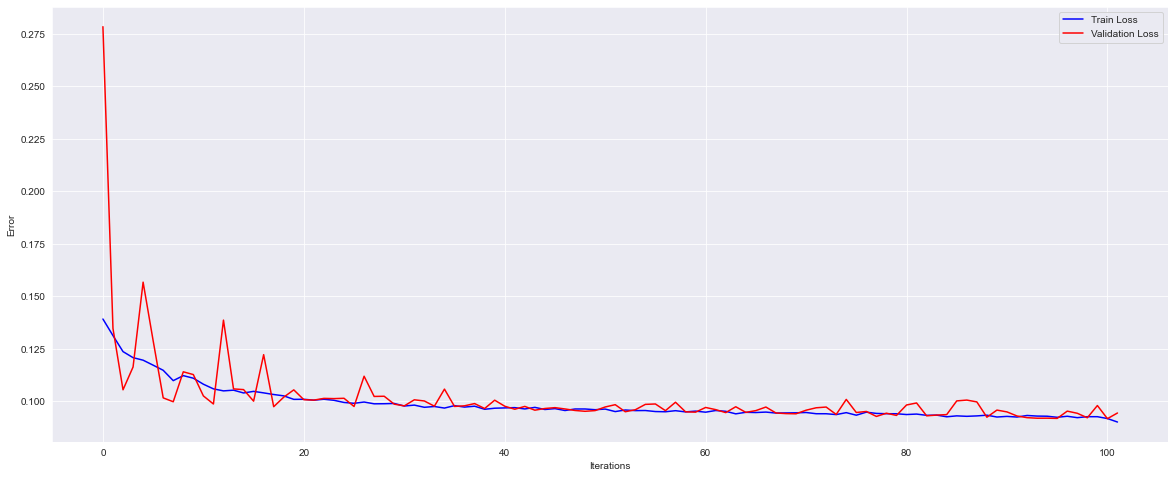

In [150]:
plt.figure(figsize=(20,8))
plt.plot(err_train, label='Train Loss', color='b')
plt.plot(err_val, label='Validation Loss', color='r')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend();

Рассчитаем значение доли неправильных ответов на обучающей и контрольной выборке.

In [151]:
res_train = neural_net.activateOnDataset(ds_train).argmax(axis=1)
print('Train Loss: ', percentError(res_train, ds_train['target'].argmax(axis=1)),'%')

res_test = neural_net.activateOnDataset(ds_test).argmax(axis=1)
print('Validation Loss: ', percentError(res_test, ds_test['target'].argmax(axis=1)),'%')

Train Loss:  45.0402144772118 %
Validation Loss:  40.625 %


### Задание. Определение оптимального числа нейронов.
В задании требуется исследовать зависимость ошибки на контрольной выборке в зависимости от числа нейронов в скрытом слое сети. Количество нейронов, по которому предполагается провести перебор, записано в векторе 
```
hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
```

1. Для фиксированного разбиения на обучающую и контрольную части подсчитайте долю неправильных ответов (ошибок) классификации на обучении/контроле в зависимости от количества нейронов в скрытом слое сети. Запишите результаты в массивы ```res_train_vec``` и ```res_test_vec```, соответственно. С помощью функции ```plot_classification_error``` постройте график зависимости ошибок на обучении/контроле от количества нейронов. Являются ли графики ошибок возрастающими/убывающими? При каком количестве нейронов достигается минимум ошибок классификации?

2. С помощью функции ```write_answer_nn``` запишите в выходной файл число: количество нейронов в скрытом слое сети, для которого достигается минимум ошибки классификации на контрольной выборке.

In [152]:
%%time
random.seed(0)
np.random.seed(0)

hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
train_loss_epochs = list()
validation_loss_epochs = list()

res_train_vec = list()
res_test_vec = list()

for n_neurons in hidden_neurons_num:
    neural_net = buildNetwork(ds_train.indim, n_neurons, ds_train.outdim, outclass=SoftmaxLayer)
    init_params = np.random.random((len(neural_net.params)))
    neural_net._setParameters(init_params)
    
    trainer = BackpropTrainer(neural_net, dataset=ds_train)
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
    train_loss_epochs.append(err_train)
    validation_loss_epochs.append(err_val)
    
    res_train = neural_net.activateOnDataset(ds_train).argmax(axis=1)
    res_train_vec.append(percentError(res_train, ds_train['target'].argmax(axis=1)))
    
    res_test = neural_net.activateOnDataset(ds_test).argmax(axis=1)
    res_test_vec.append(percentError(res_test, ds_test['target'].argmax(axis=1)))

Wall time: 5min 32s


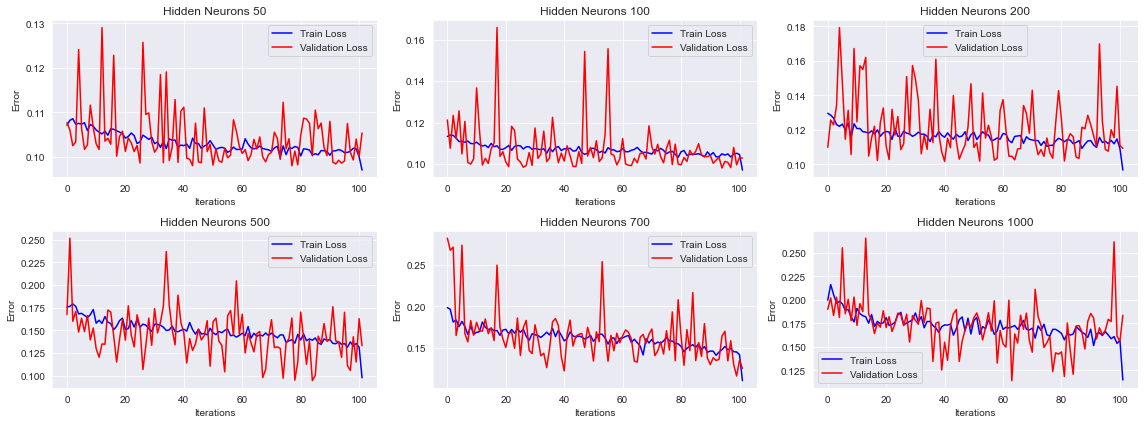

In [153]:
# Кривые обучения
fig, axes = plt.subplots(2,3, figsize=(16,6))
for indx, val in enumerate(hidden_neurons_num):
    axes[indx // 3, indx % 3].plot(train_loss_epochs[indx], label='Train Loss', color='b')
    axes[indx // 3, indx % 3].plot(validation_loss_epochs[indx], label='Validation Loss', color='r')
    axes[indx // 3, indx % 3].set_xlabel('Iterations')
    axes[indx // 3, indx % 3].set_ylabel('Error')
    axes[indx // 3, indx % 3].set_title(f'Hidden Neurons {val}')
    axes[indx // 3, indx % 3].legend();
    plt.tight_layout()

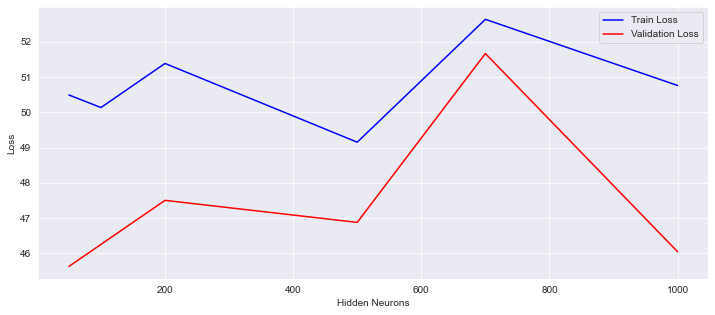

In [154]:
plt.figure(figsize=(12,5))
plt.plot(hidden_neurons_num, res_train_vec, label='Train Loss', c='b')
plt.plot(hidden_neurons_num, res_test_vec, label='Validation Loss', c='r')
plt.xlabel('Hidden Neurons')
plt.ylabel('Loss')
plt.legend();

На самом деле задание устарело и нет времени вникать в подробности. Ход решения верен, а правильный ответ 700.

Самый минимум достигается при 50 нейронах

In [156]:
def write_answer_nn(optimal_neurons_num):
    with open("nnets_answer1.txt", "w") as f :
        f.write(str(optimal_neurons_num))

write_answer_nn(700)